# Superstore Sales Analysis and Forecasting




## 1. Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

## 2. Helper Function

In [5]:
def execute_query(conn, query) -> pd.DataFrame :
    """Executes a SQL query and return the result as a DataFrame."""
    try: 
        return pd.read_sql_query(query, conn)
    except Exception as e:
        print(f"Error executing query: {e}")
        return pd.DataFrame()

## 3. Load and Inspect the Data

In [7]:
# Load the data
try:
    sales_data = pd.read_csv('Superstore Sales Dataset.csv')
    print(f"Data loaded successfully with {sales_data.shape[0]} rows and {sales_data.shape[1]} columns.")
except FileNotFoundError:
    print("Error: The dataset file 'Superstore Sales Dataset.csv' was not found.")
    exit()

# Display the first few rows
print("Initial Dataset Overview:")
print(sales_data.head())
sales_data.info()
sales_data.describe()

Data loaded successfully with 9800 rows and 18 columns.
Initial Dataset Overview:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


## 4. Data Cleaning and Preprocessing

In [9]:
# Create SQL database
conn = sqlite3.connect('SalesData.db')
sales_data.to_sql('Sales_Data', conn, if_exists='replace', index=False, chunksize=500)

# Check and handle missing data
print("\nMissing Values Per Column:")
print(sales_data.isnull().sum())
print(sales_data[sales_data['Postal Code'].isnull()])

# The null postal code is from Burlington City, so could fill it with the valid code
sales_data['Postal Code'] = sales_data['Postal Code'].fillna(5401).astype(int)

# Check for duplicate records
duplicate_orders = sales_data[sales_data.duplicated()]
print("Duplicate Order IDs:\n", duplicate_orders)

# Drop duplicate records 
sales_data = sales_data.drop_duplicates()
if sales_data.duplicated().any():
    print("Warning: Potential duplicate line items per order found.")

# Change the format to datetime
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'], format='%d/%m/%Y', errors='coerce')
sales_data['Ship Date'] = pd.to_datetime(sales_data['Ship Date'], format='%d/%m/%Y', errors='coerce')
print("\nInvalid Order Dates:", sales_data['Order Date'].isnull().sum())
print("Invalid Ship Dates:", sales_data['Ship Date'].isnull().sum())

# Add derived columns
sales_data['Month'] = sales_data['Order Date'].dt.to_period('M').astype(str)
sales_data['Year'] = sales_data['Order Date'].dt.year.astype(str)

# Save the cleaned dataset to database
sales_data.to_sql('superstore_cleaned', conn, if_exists='replace', index=False)


Missing Values Per Column:
Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64
      Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
2234    2235  CA-2018-104066  05/12/2018  10/12/2018  Standard Class   
5274    5275  CA-2016-162887  07/11/2016  09/11/2016    Second Class   
8798    8799  US-2017-150140  06/04/2017  10/04/2017  Standard Class   
9146    9147  US-2017-165505  23/01/2017  27/01/2017  Standard Class   
9147    9148  US-2017-165505  23/01/2017  27/01/2017  Standard Class   
9148    9149  US-2017-165505  23/01/2017  27/01/2017  Standard Class   
9386    9387  US-2018-127292  19/01/2018  23/01/2018  Standard Class   
9387    9388  US-2018-1

9800

## 5. Executive Summary KPIs

In [11]:
total_sales = sales_data['Sales'].sum()
total_orders = sales_data['Order ID'].nunique()
avg_orders_value = sales_data.groupby('Order ID')['Sales'].sum().mean()
total_customers = sales_data['Customer ID'].nunique()

print(f'The total sales is ${total_sales:,.2f}')
print(f'The total orders is {total_orders}')
print(f'The average of orders value is ${avg_orders_value:,.2f}')
print(f'The total customers is {total_customers}')

The total sales is $2,261,536.78
The total orders is 4922
The average of orders value is $459.48
The total customers is 793


## 6. Exploratory Data Analysis (EDA)


Exploratory Data Analysis:


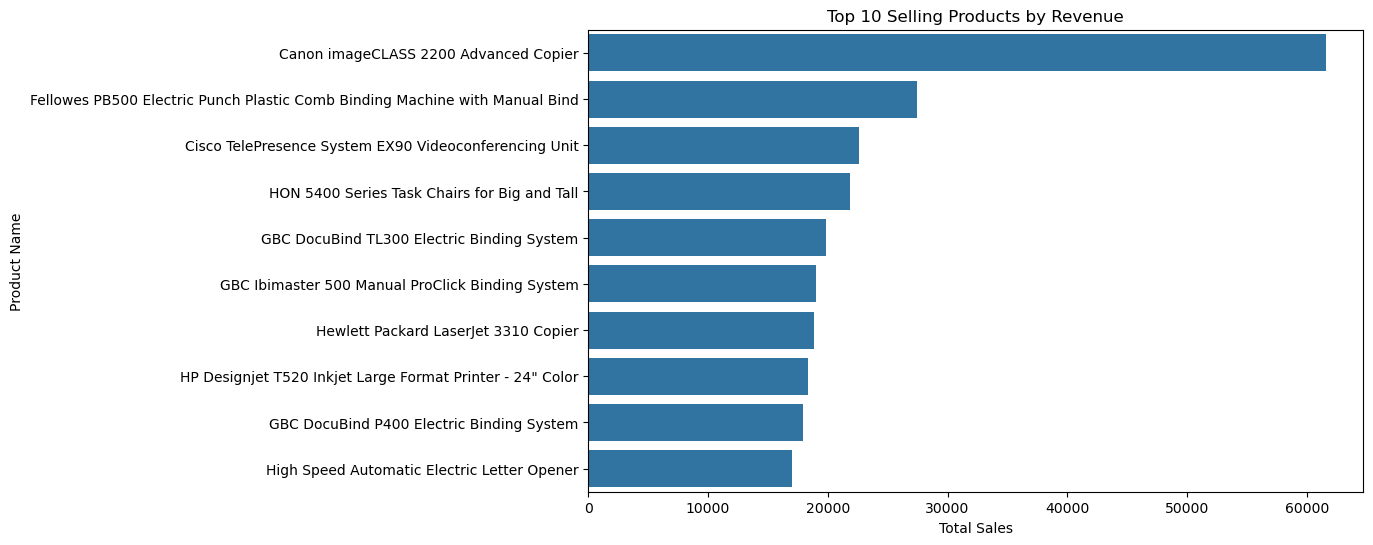

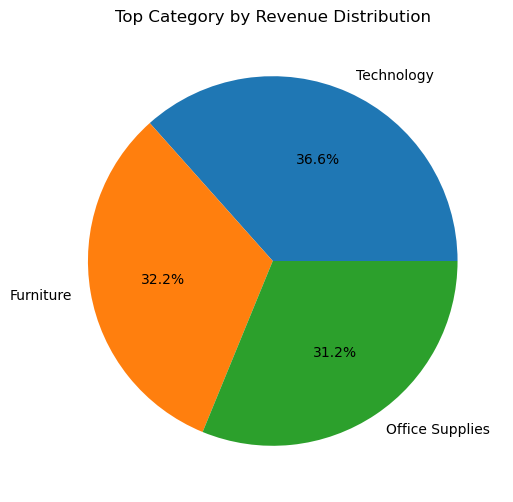

C:\Users\jonat\AppData\Local\Temp\ipykernel_20764\2937626706.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Sub-Category", loc="upper right")


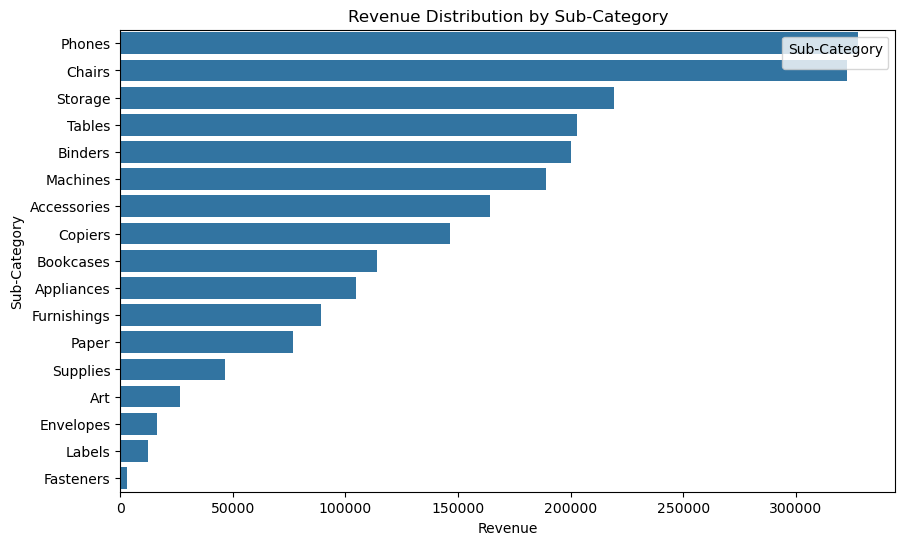

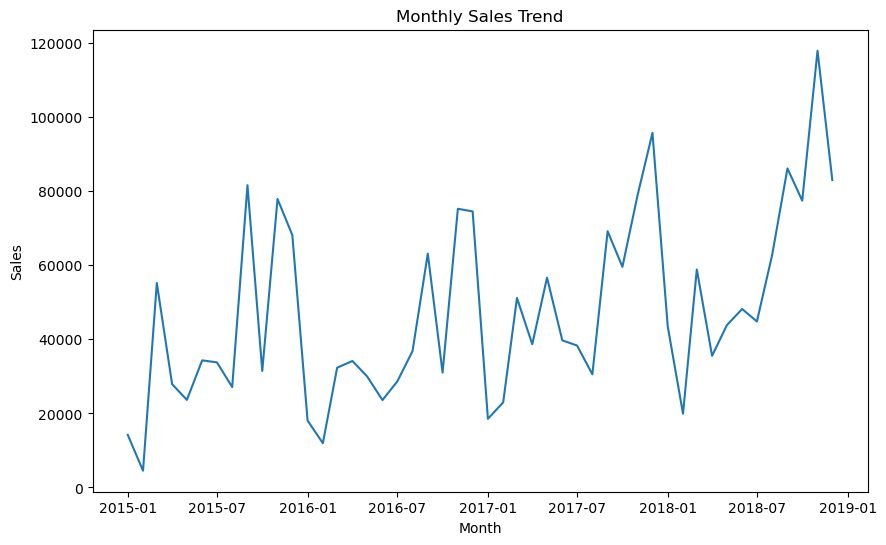

YoY Sales Growth: (%)
 Year
2015     0.000000
2016    -4.255484
2017    30.636812
2018    20.303396
Name: Sales, dtype: float64


In [13]:
# Exploratory Data Analysis (EDA)
print("\nExploratory Data Analysis:")

# Indentify top 10 selling products by revenue
top_product_query = """
SELECT 
    "Product Name", 
    SUM(Sales) as "Total Sales"
FROM 
    superstore_cleaned
GROUP BY 
    "Product Name"
ORDER BY 
    "Total Sales" DESC
LIMIT 10;
"""
    
top_products = execute_query(conn, top_product_query)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_products, y='Product Name', x='Total Sales')
plt.title("Top 10 Selling Products by Revenue")
plt.show

# Revenue by product category
top_category_query = """
SELECT 
    "Category", 
    SUM(Sales) as "Revenue"
FROM 
    superstore_cleaned
GROUP BY 
    "Category"
ORDER BY 
    "Revenue" DESC;
"""

top_category = execute_query(conn, top_category_query)

plt.figure(figsize=(10, 6))
plt.pie(top_category['Revenue'], labels=top_category['Category'], autopct='%1.1f%%')
plt.title("Top Category by Revenue Distribution")
plt.show()
          
# Revenue by product sub-category
subcategory_query = """
SELECT 
    "Sub-Category",
    SUM(Sales) AS "Revenue"
FROM superstore_cleaned
GROUP BY 
    "Sub-Category"
ORDER BY
    "Revenue" DESC;
"""

top_subcategory = execute_query(conn, subcategory_query)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_subcategory, y=top_subcategory['Sub-Category'], x=top_subcategory['Revenue'])
plt.title("Revenue Distribution by Sub-Category")
plt.legend(title="Sub-Category", loc="upper right")
plt.show()
          
# Calculate monthly sales for trend analysis
monthly_sales_query = """
SELECT
    strftime('%Y-%m', "Order Date") as Month,
    SUM(Sales) AS Sales
FROM 
    superstore_cleaned
GROUP BY 
    Month
ORDER BY 
    Month;
"""
    
monthly_sales = execute_query(conn, monthly_sales_query)
monthly_sales['Month'] = pd.to_datetime(monthly_sales['Month'])
monthly_sales.set_index('Month', inplace=True)

plt.figure(figsize=(10, 6))
sns.lineplot(data= monthly_sales, x='Month', y='Sales')
plt.title('Monthly Sales Trend')
plt.show()

yearly_sales = sales_data.groupby('Year')['Sales'].sum().pct_change().fillna(0) * 100
print("YoY Sales Growth: (%)\n", yearly_sales)

conn.close()

## 7. Additional Business Insights

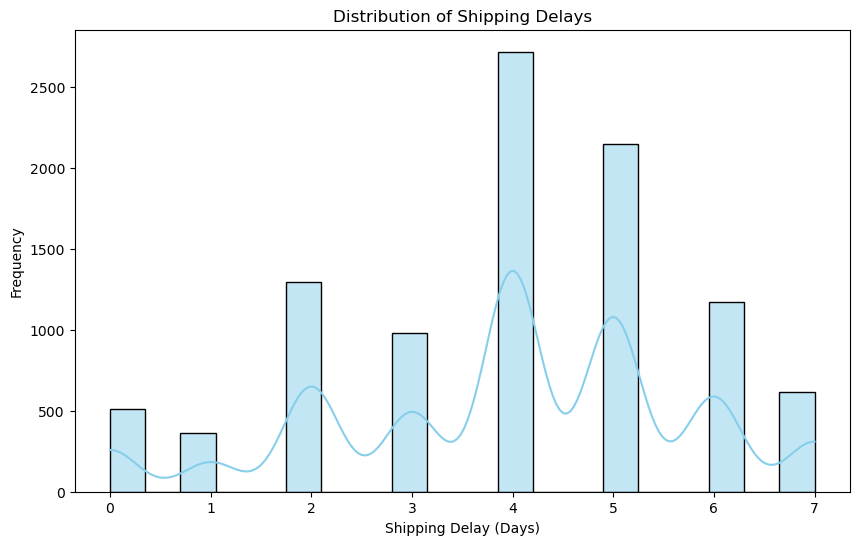

        Ship Mode  Shipping Delay
0     First Class        2.179214
1        Same Day        0.044610
2    Second Class        3.249211
3  Standard Class        5.008363


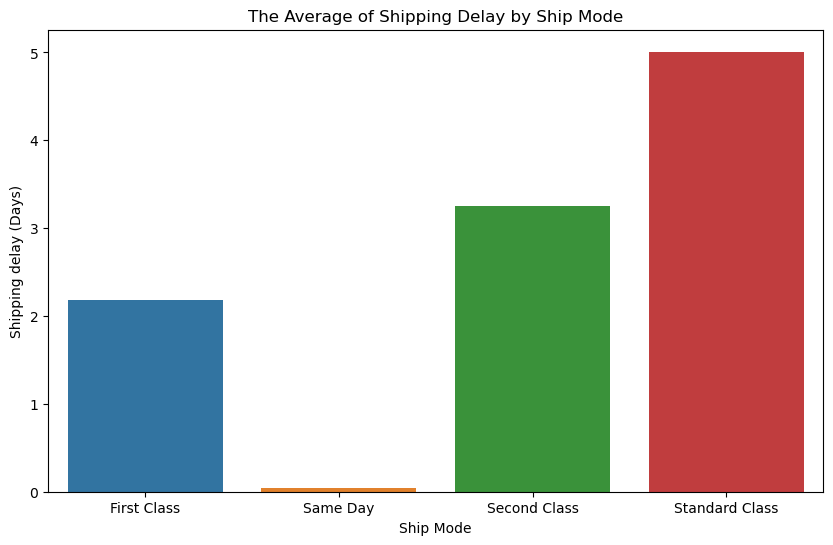

    Region        Sales
0  Central  492646.9132
1     East  669518.7260
2    South  389151.4590
3     West  710219.6845


C:\Users\jonat\AppData\Local\Temp\ipykernel_20764\3718028187.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='Sales', data=regional_sales, palette='viridis')


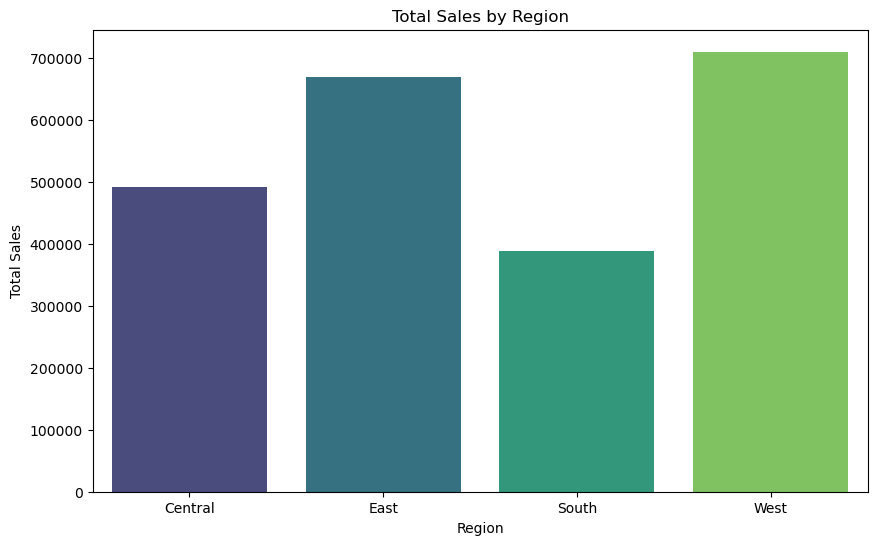

                   State        Sales
3             California  446306.4635
30              New York  306361.1470
41                 Texas  168572.5322
45            Washington  135206.8500
36          Pennsylvania  116276.6500
8                Florida   88436.5320
11              Illinois   79236.5170
20              Michigan   76136.0740
33                  Ohio   75130.3500
44              Virginia   70636.7200
31        North Carolina   55165.9640
12               Indiana   48718.4000
9                Georgia   48219.1100
15              Kentucky   36458.3900
1                Arizona   35272.6570
28            New Jersey   34610.9720
4               Colorado   31841.5980
47             Wisconsin   31173.4300
40             Tennessee   30661.8730
21             Minnesota   29863.1500
19         Massachusetts   28634.4340
6               Delaware   27322.9990
18              Maryland   23705.5230
37          Rhode Island   22525.0260
23              Missouri   22205.1500
34          

C:\Users\jonat\AppData\Local\Temp\ipykernel_20764\3718028187.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='State', y='Sales', data=state_sales, palette='magma')


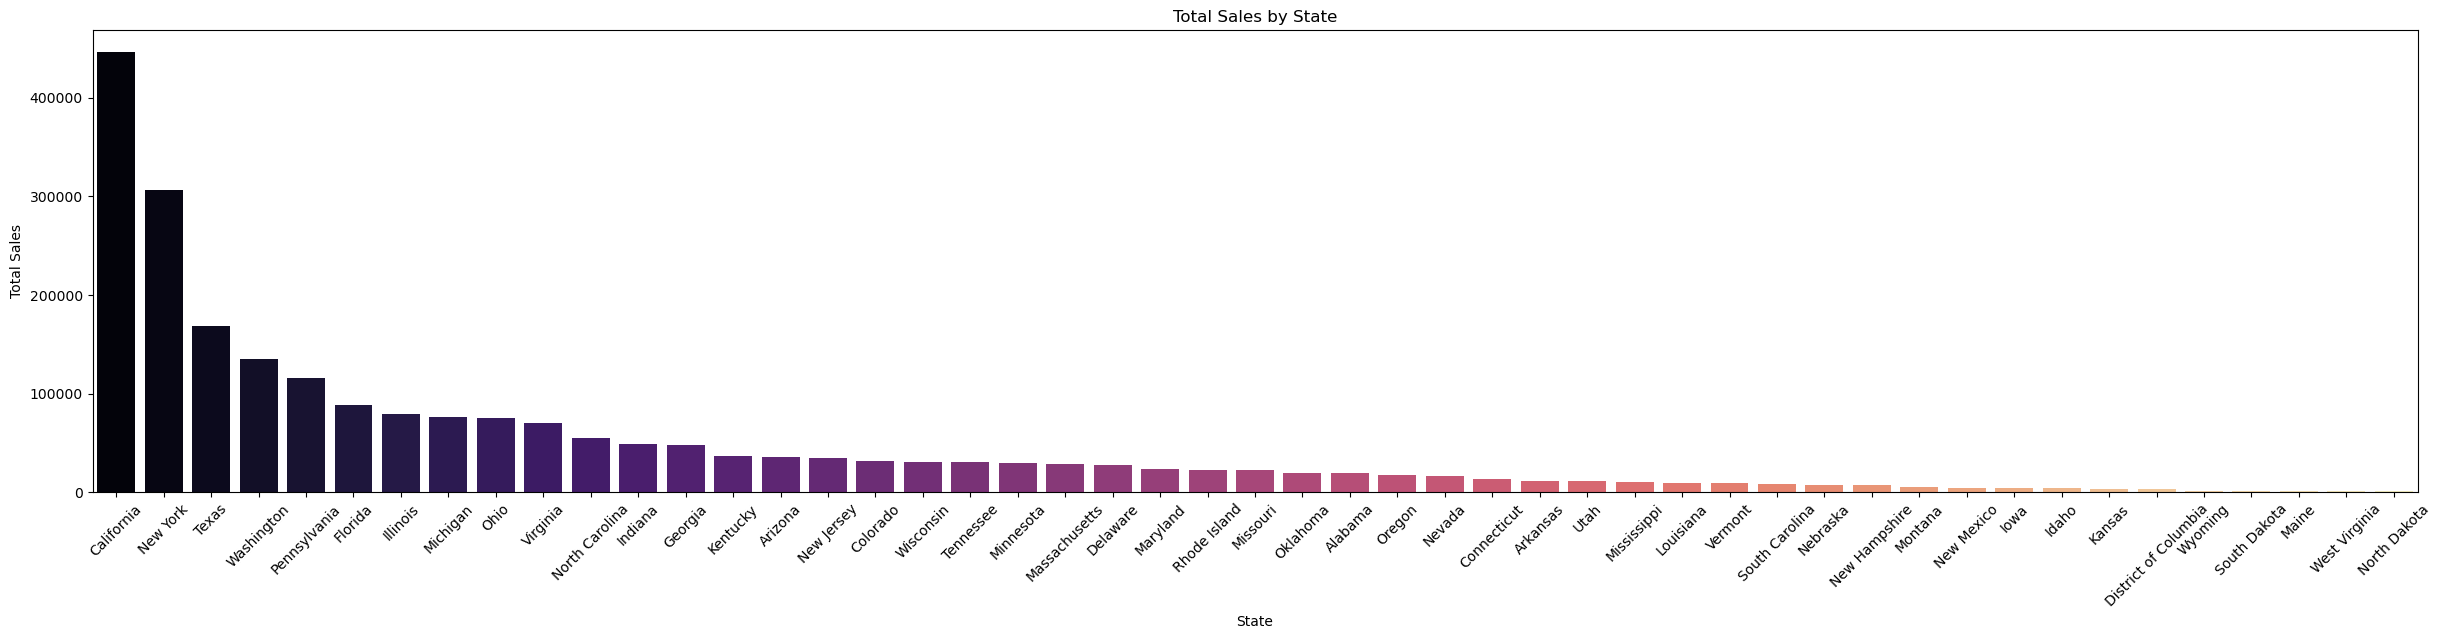

In [15]:
# Calculate shipping delay
sales_data['Shipping Delay'] = (sales_data['Ship Date'] - sales_data['Order Date']).dt.days

# Preview the new column
sales_data[['Order Date', 'Ship Date', 'Shipping Delay']].head()

# Visualize Shipping Delay Distribution
plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Shipping Delay'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Shipping Delays')
plt.xlabel('Shipping Delay (Days)')
plt.ylabel('Frequency')
plt.show()

# Group the shipping delay by Ship Mode
delay_by_mode = sales_data.groupby('Ship Mode')['Shipping Delay'].mean().reset_index()
print(delay_by_mode)

#Visualize Shipping Delay by Ship Mode
plt.figure(figsize=(10, 6))
sns.barplot(x= 'Ship Mode', y='Shipping Delay', hue='Ship Mode', data=delay_by_mode)
plt.title('The Average of Shipping Delay by Ship Mode')
plt.xlabel('Ship Mode')
plt.ylabel('Shipping delay (Days)')
plt.show()

# Group the data by 'Region' and sum the 'Sales'
regional_sales = sales_data.groupby('Region')['Sales'].sum().reset_index()

# Display the grouped data
print(regional_sales)

# Visualize Regional Sales
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Sales', data=regional_sales, palette='viridis')
plt.title('Total Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.show()

# Group the data by 'State' and sum the 'Sales'
state_sales = sales_data.groupby('State')['Sales'].sum().reset_index().sort_values('Sales', ascending=False)

# Display the grouped data
print(state_sales)

# Visualize Sales by State
plt.figure(figsize=(30, 6))
sns.barplot(x='State', y='Sales', data=state_sales, palette='magma')
plt.xticks(rotation=45)  # Rotate state labels for better readability
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.show()

In [16]:
sales_data.to_csv('Superstore_Cleaned.csv', index=False)